# <u><b>Late Delliveries, Proposed Solutions to Olist</b></u>

A late delivery occurs when an order's actual shipping date exceeds its estimated delivery date. This creates a gap between customer expectations and our operational capabilities. So we propose the following solutions:

1. *Develop more realistic delivery timeframes based on historical data, ensuring we can consistently meet or exceed customer expectations*



In [193]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

import matplotlib.pyplot as plt # type: ignore

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

import joblib

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [194]:
# plotting 
def plot_data(df, col_plot_1, col_plot_2, label_plot_1, label_plot_2, title):
    fig, ax1 = plt.subplots(figsize=(20, 8))

    ax1.plot(df[col_plot_1], color='blue', marker='o')
    ax1.set_ylabel(label_plot_1, color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df[col_plot_2], color='orange', alpha=0.5, marker='o')
    ax2.set_ylabel(label_plot_2, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    fig.suptitle(title, fontsize=16)
    ax1.set_xlabel('Date')
    plt.show()

In [195]:
df = pd.read_csv("../data/processed/data.csv", parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'])

df['purchase_date_hour'] = df['order_purchase_timestamp'].dt.floor('H')
df['gap_in_minutes_approved_and_ordered'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600
df['order_purchase_date'] = pd.to_datetime(df['order_purchase_timestamp'].dt.date)
df['year'] = df['order_purchase_timestamp'].dt.year

temp_df = df[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date',  'late_delivery_in_days', 'is_delivery_late', 
              'month', 'year', 'purchase_date_hour', 'gap_in_minutes_approved_and_ordered', 'order_purchase_date']]

# <u><b>Olist's Late Delivery Rate</b></u>

### Percentage of late deliveries

In [196]:
temp_df['is_delivery_late'].value_counts(normalize=True)

is_delivery_late
0    0.935842
1    0.064158
Name: proportion, dtype: float64

### Percentage of late deliveries by month

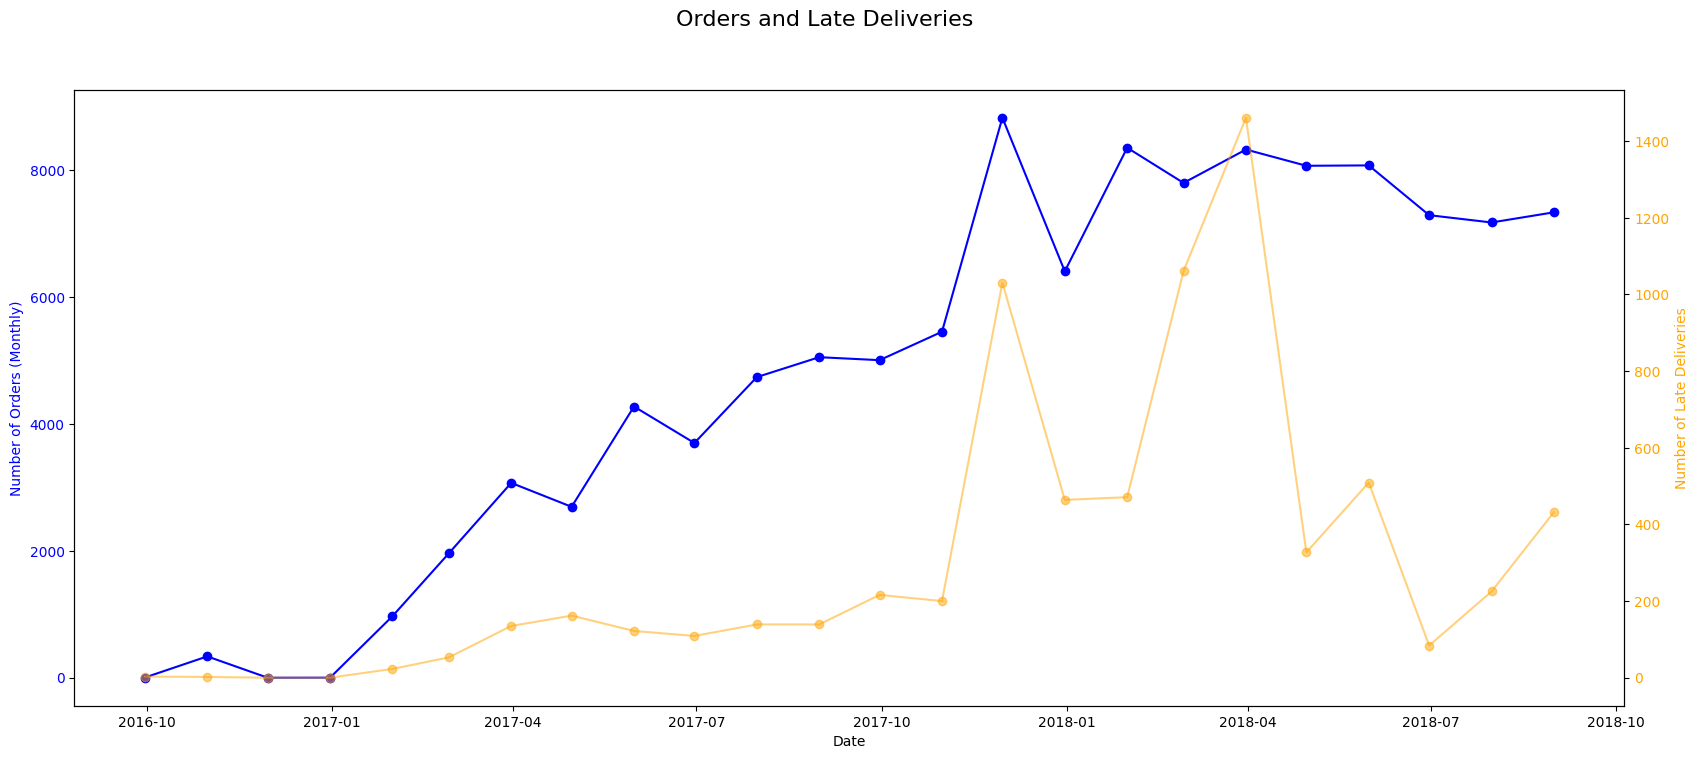

In [197]:
monthly_data = temp_df.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

plot_data(df=monthly_data,
          col_plot_1='count_orders', 
          col_plot_2='num_late_deliveries', 
          label_plot_1='Number of Orders (Monthly)', 
          label_plot_2='Number of Late Deliveries', 
          title='Orders and Late Deliveries')

### Percentage of late deliveries by week

Group by week and counting the total number of orders and number of late deliveries

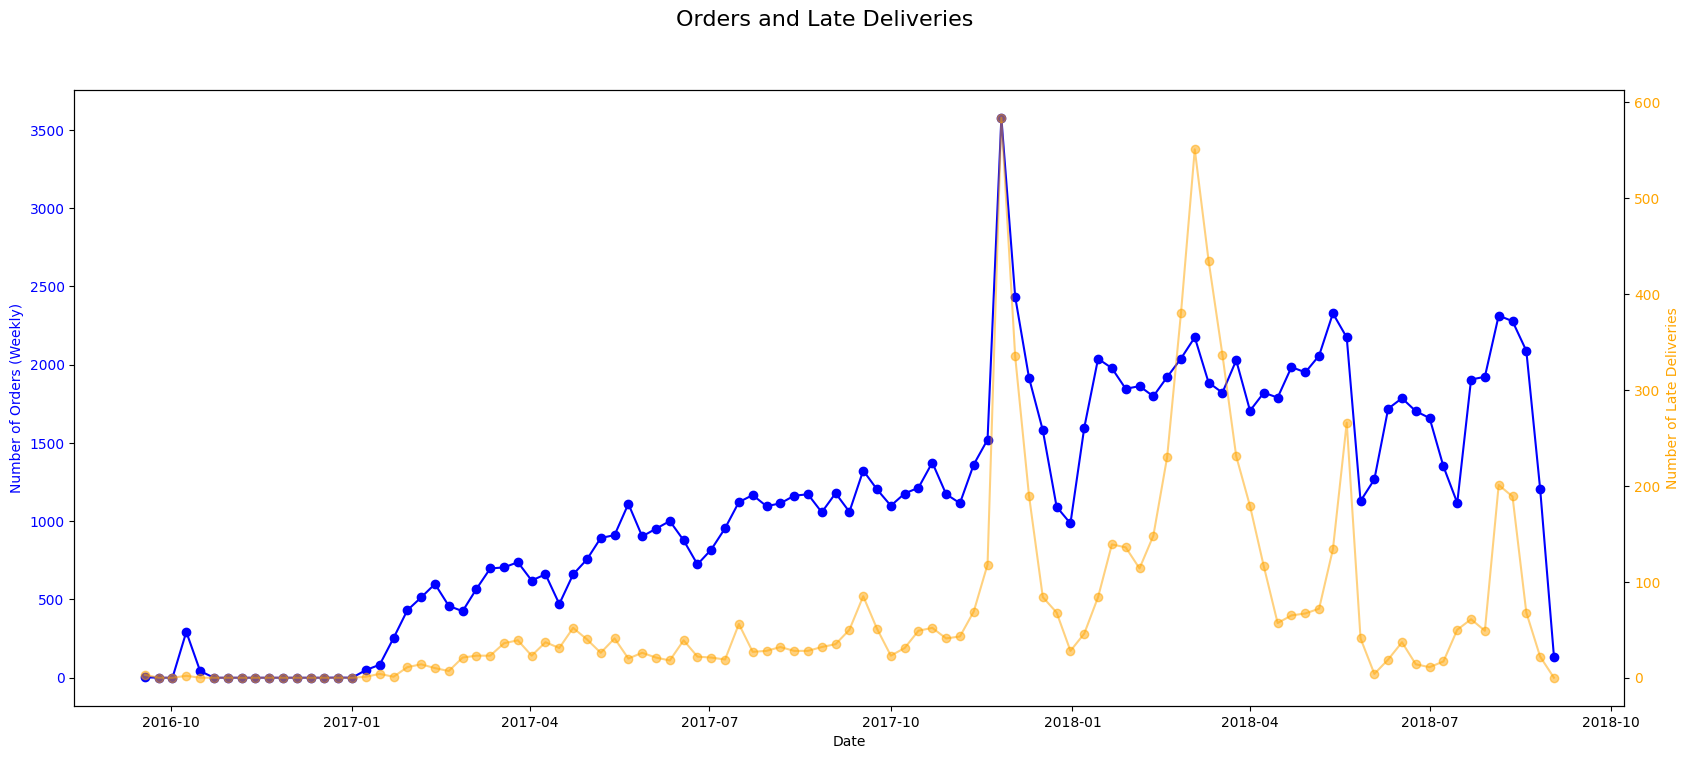

In [198]:
weekly_data = temp_df.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

plot_data(df=weekly_data,
          col_plot_1='count_orders', 
          col_plot_2='num_late_deliveries', 
          label_plot_1='Number of Orders (Weekly)', 
          label_plot_2='Number of Late Deliveries', 
          title='Orders and Late Deliveries')

---

# <u><b>Solution</b></u>


1. *Rely on predictive Machine Learning models to develop a more realistic delivery timeframes based on historical data, ensuring we can consistently meet or exceed customer expectations*


The Olist dataset provides both the **ordered_delivered_customer_date** and the **order_estimated_delivery_date**, enabling us to calculate the **late deliveries rate**. Our goal is to develop a machine learning model that can predict delivery dates more accurately than Olist's current system, reducing the rate of late deliveries. By improving delivery prediction accuracy, we can enhance customer satisfaction.




In [199]:
def late_delivery_rate(y_true, y_pred):
    # This is the metric we want to optimize for
    late_deliveries = np.sum(y_pred < y_true)
    return late_deliveries / len(y_true)

def coverage_rate(y_true, lower_bound, upper_bound):
    # Check if actual values fall within the interval
    within_interval = (y_true >= lower_bound) & (y_true <= upper_bound)
    return np.mean(within_interval)

### Feature Engineering and Dependent Variable

- To improve our model's accuracy, we can incorporate a feature for the late delivery rate in the weeks prior to the order. This will help capture seasonal trends, such as holiday periods.

In [200]:
df['dow'] = df['order_purchase_timestamp'].dt.day_of_week
df['hour'] = df['order_purchase_timestamp'].dt.hour

df['days_to_actual_delivery'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days
df['days_to_actual_delivery_log'] = np.log(df['days_to_actual_delivery']+1)
df['days_to_estimated_delivery'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days

df['is_december'] = 0
df.loc[df['month'].isin([11,12]), 'is_december'] = 1

df['is_summer'] = 0
df.loc[df['month'].isin([5,6,7,8]), 'is_summer'] = 1

In [201]:
df_clean = df.drop_duplicates(subset=['order_id'])
df_clean.sort_values(by='order_purchase_timestamp', inplace=True)

df_clean['purchase_date_hour'] = df_clean['order_purchase_timestamp'].dt.floor('H')
df_clean['week_start'] = (df['order_purchase_timestamp'] - pd.to_timedelta(df['order_purchase_timestamp'].dt.weekday + 1, unit='D')).dt.date
df_clean['week_start'] = pd.to_datetime(df_clean['week_start'])

weekly_data = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum')).reset_index()

weekly_data['perc_late_deliveries'] = weekly_data['num_late_deliveries'] / weekly_data['count_orders']
weekly_data['perc_late_deliveries'].fillna(0, inplace=True)

df_clean = pd.merge(df_clean, weekly_data, how='left', left_on='week_start', right_on='order_purchase_date', suffixes=('', '_duplicate'))

# Lagging the weekly percentage late deliveries variable to know the late delivery rate from the previous weeks
for i in range(1,3):
    df_clean[f'perc_late_deliveries_lag_{i}'] = df_clean['perc_late_deliveries'].shift(i)
    df_clean.dropna(subset=[f'perc_late_deliveries_lag_{i}'], inplace=True)

In [202]:
df_clean[['days_to_actual_delivery', 'perc_late_deliveries', 'perc_late_deliveries_lag_1', 'perc_late_deliveries_lag_2']].corr()

,days_to_actual_delivery,perc_late_deliveries,perc_late_deliveries_lag_1,perc_late_deliveries_lag_2
days_to_actual_delivery,1.000000,0.188378,0.188358,0.188346
perc_late_deliveries,0.188378,1.000000,0.999881,0.999763
perc_late_deliveries_lag_1,0.188358,0.999881,1.000000,0.999881
perc_late_deliveries_lag_2,0.188346,0.999763,0.999881,1.000000



**Problem:** Olist's current model has a late delivery rate of **7.2%**, setting our benchmark.

**Solution:** Build a predictive model that outperforms this benchmark using the available features.

In [203]:
olist_model_late_delivery_rate = late_delivery_rate(df['days_to_actual_delivery'], df['days_to_estimated_delivery'])
print(f"Late Delivery Rate for Olist current estimated delivery model: {olist_model_late_delivery_rate:.4f}")

Late Delivery Rate for Olist current estimated delivery model: 0.0720


## Features

In [170]:
features = [
'is_summer',
'freight_value',
'distance_km',
'month',
'dow',
'is_december',
'perc_late_deliveries_lag_1']

target = 'days_to_actual_delivery_log'
X, y = df_clean[features], df_clean[target]

## Ensemble Model

**Gradient Boosting**

We're using days to actual delivery as our dependent variable, calculated as the difference between the order purchase date and the actual delivery date. Our goal is to predict the number of days from order placement to delivery.

To create our target variable, "**is_late_delivery**," we'll apply the following logic:

- Late Delivery: Days to Actual Delivery > Days to Estimated Delivery (model's prediction)
- On-Time Delivery: Days to Actual Delivery <= Days to Estimated Delivery

However, model errors can occur in two ways:

1. **Overestimation**: Predicting a longer delivery time than the actual time.
2. **Underestimation**: Predicting a shorter delivery time than the actual time.
While overestimation can sometimes be preferable (early delivery), underestimation is more critical, as it leads to late deliveries and potential customer dissatisfaction.

To address this, we'll estimate a 95% confidence interval for the days to estimated delivery, focusing on minimizing the risk of underestimation.

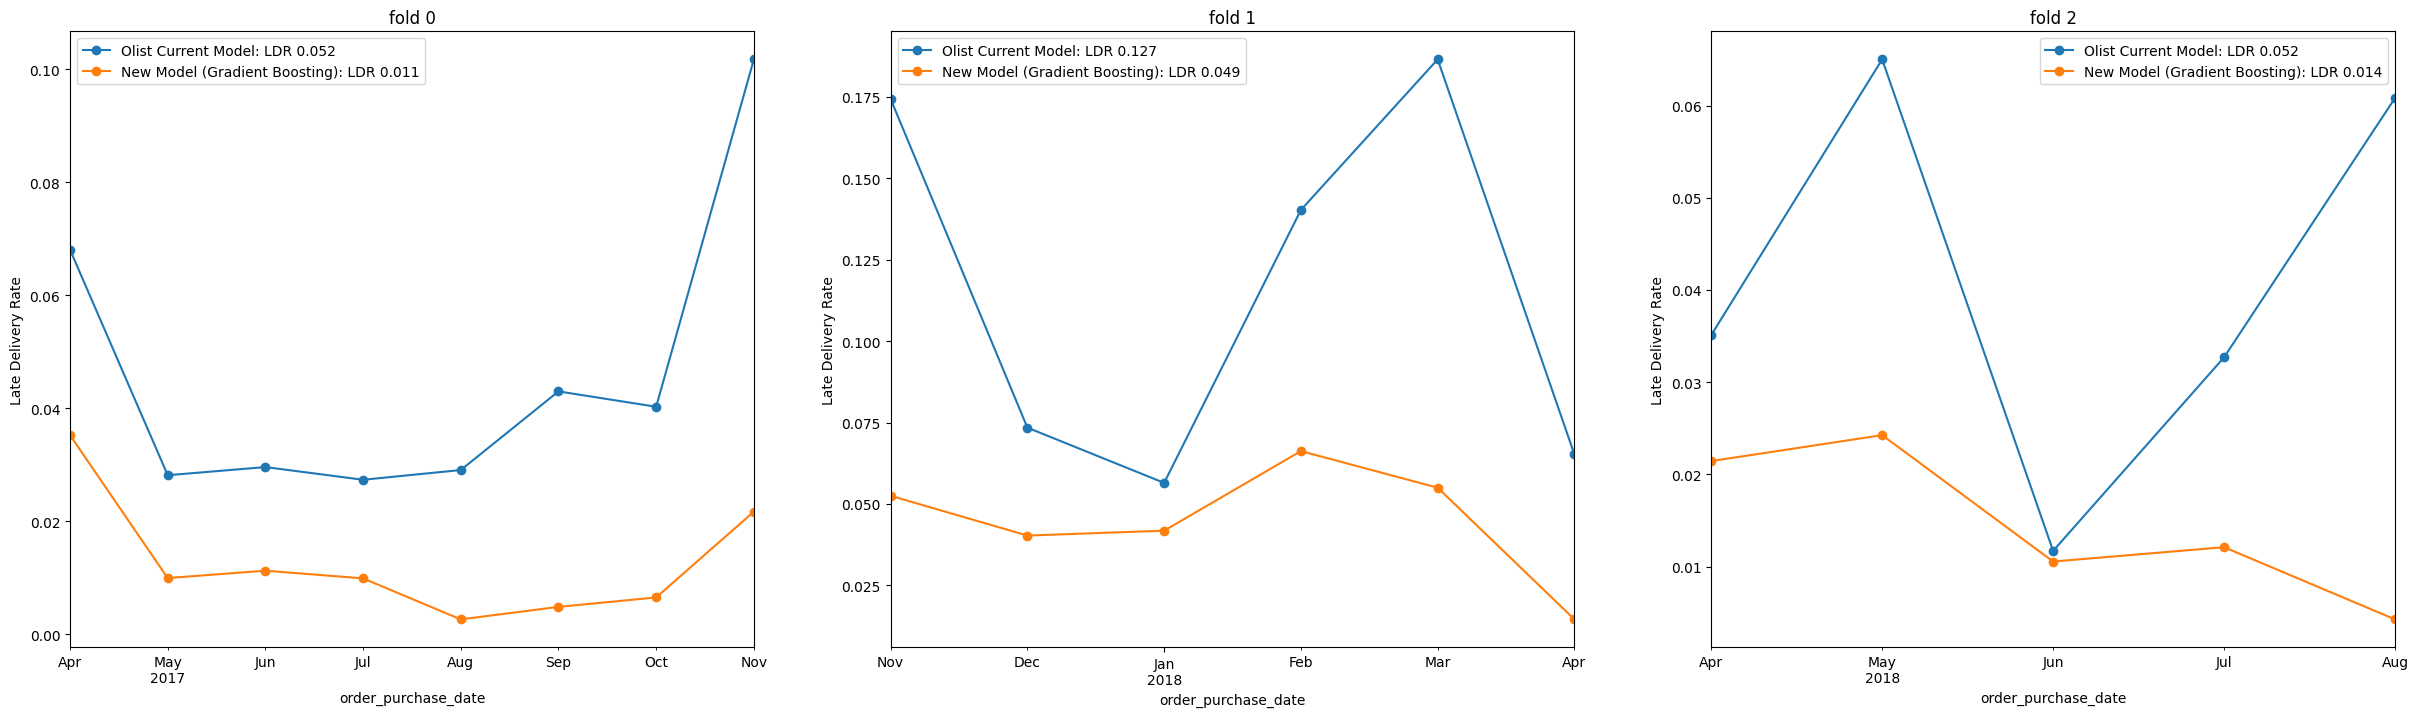

In [204]:
tss = TimeSeriesSplit(n_splits=3, test_size=30000)
fig, axs = plt.subplots(1,3,figsize=(30,8))
fold = 0


for train_idx, val_idx in tss.split(df_clean):

    train_set = df_clean.iloc[train_idx]
    validation_set = df_clean.iloc[val_idx]

    X_train, y_train = train_set[features], train_set[target]
    X_val, y_val = validation_set[features], validation_set[target]

    # Lower bound model (2.5th percentile)
    lower_model = GradientBoostingRegressor(loss="quantile", alpha=0.025, random_state=42)
    lower_model.fit(X_train, y_train)

    # Upper bound model (97.5th percentile)
    upper_model = GradientBoostingRegressor(loss="quantile", alpha=0.975, random_state=42)
    upper_model.fit(X_train, y_train)

    # Predictions
    lower_bound = lower_model.predict(X_val)
    upper_bound = upper_model.predict(X_val)

    # ----------------- Plotting
    validation_set['days_to_estimated_delivery_model_lb'] = np.exp(lower_bound) - 1
    validation_set['days_to_estimated_delivery_model_ub'] = np.exp(upper_bound) - 1

    # Calculating late deliveries using our model
    validation_set['is_delivery_late_gb'] = np.where(validation_set['days_to_actual_delivery'] > validation_set['days_to_estimated_delivery_model_ub'], 1, 0)

    weekly_data_model_current = validation_set.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(count_orders=('order_purchase_date', 'count'), num_late_deliveries = ('is_delivery_late', 'sum'))
    weekly_data_model_gb= validation_set.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(count_orders=('order_purchase_date', 'count'), num_late_deliveries = ('is_delivery_late_gb', 'sum'))

    weekly_data_model_current['perc_late_deliveries'] = weekly_data_model_current['num_late_deliveries'] / weekly_data_model_current['count_orders']
    weekly_data_model_gb['perc_late_deliveries'] = weekly_data_model_gb['num_late_deliveries'] / weekly_data_model_gb['count_orders']

    olist_ldr = late_delivery_rate(validation_set['days_to_actual_delivery'], validation_set['days_to_estimated_delivery']).round(3)
    new_model_ldr = late_delivery_rate(y_true=y_val, y_pred=upper_bound).round(3)

    weekly_data_model_current[(weekly_data_model_current['perc_late_deliveries'].notna()) & (weekly_data_model_current['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'Olist Current Model: LDR {olist_ldr}', ax=axs[fold], marker='o')
    weekly_data_model_gb[(weekly_data_model_gb['perc_late_deliveries'].notna()) & (weekly_data_model_gb['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'New Model (Gradient Boosting): LDR {new_model_ldr}', ax=axs[fold], marker='o')
    axs[fold].legend()
    axs[fold].set_title(f"fold {fold}") 
    axs[fold].set_ylabel(f"Late Delivery Rate") 

    fold+=1


### Training Model on Full Training Data

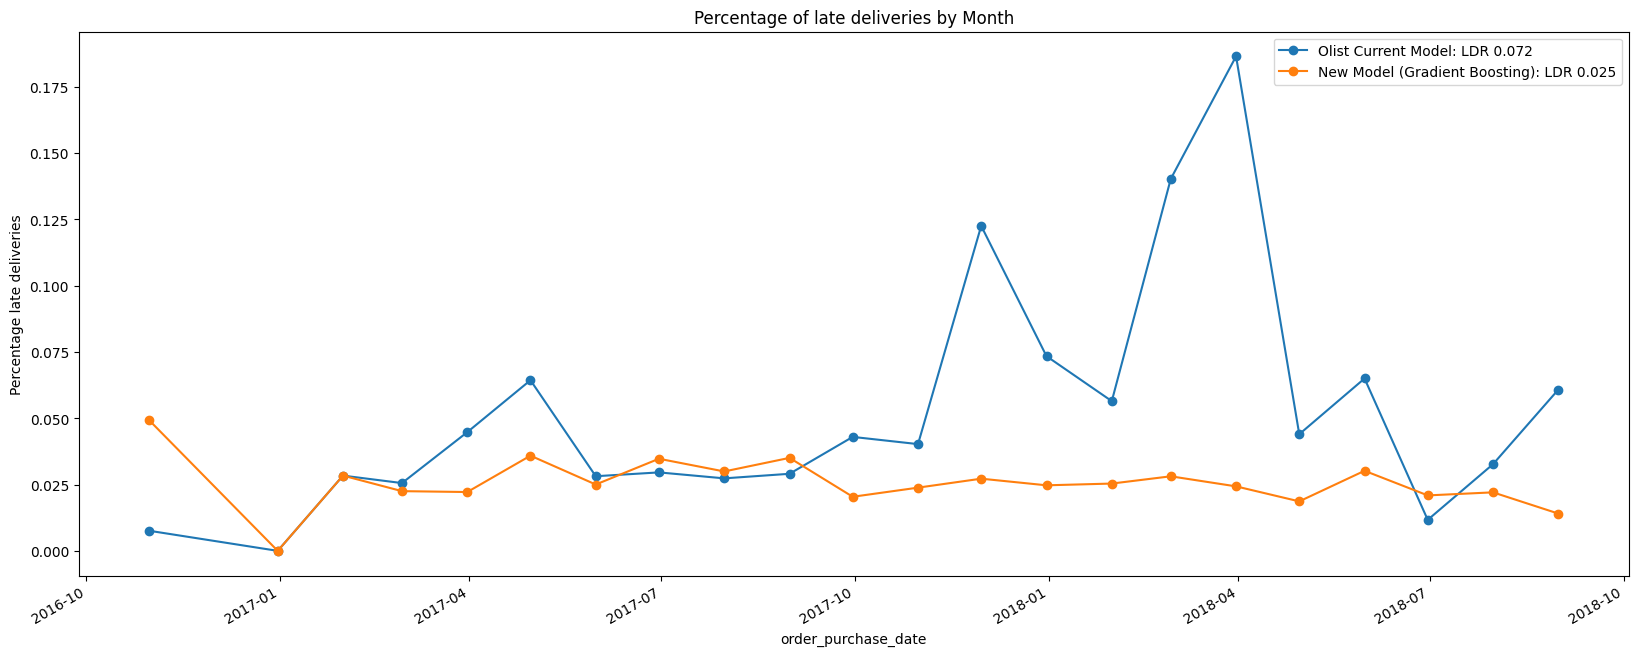

In [179]:
# Lower bound model (2.5th percentile)
lower_model = GradientBoostingRegressor(loss="quantile", alpha=0.025, random_state=42)
lower_model.fit(X, y)

# Upper bound model (97.5th percentile)
upper_model = GradientBoostingRegressor(loss="quantile", alpha=0.975, random_state=42)
upper_model.fit(X, y)

# Predictions
lower_bound = lower_model.predict(X)
upper_bound = upper_model.predict(X)

df_clean['days_to_estimated_delivery_model_lb'] = np.exp(lower_bound) - 1
df_clean['days_to_estimated_delivery_model_ub'] = np.exp(upper_bound) - 1

# Calculating late deliveries using our model
df_clean['is_delivery_late_gb'] = np.where(df_clean['days_to_actual_delivery'] > df_clean['days_to_estimated_delivery_model_ub'], 1, 0)

# Plotting
weekly_data_model_current = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late', 'sum'))

weekly_data_model_gb= df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='M')).agg(
    count_orders=('order_purchase_date', 'count'),
    num_late_deliveries = ('is_delivery_late_gb', 'sum'))

weekly_data_model_current['perc_late_deliveries'] = weekly_data_model_current['num_late_deliveries'] / weekly_data_model_current['count_orders']
weekly_data_model_gb['perc_late_deliveries'] = weekly_data_model_gb['num_late_deliveries'] / weekly_data_model_gb['count_orders']

olist_ldr = late_delivery_rate(df['days_to_actual_delivery'], df['days_to_estimated_delivery']).round(3)
new_model_ldr = late_delivery_rate(y_true=y, y_pred=upper_bound).round(3)

plt.figure(figsize=(20, 8))
weekly_data_model_current[(weekly_data_model_current['perc_late_deliveries'].notna()) & (weekly_data_model_current['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'Olist Current Model: LDR {olist_ldr}', marker='o')
weekly_data_model_gb[(weekly_data_model_gb['perc_late_deliveries'].notna()) & (weekly_data_model_gb['perc_late_deliveries'] != 1)]['perc_late_deliveries'].plot(label=f'New Model (Gradient Boosting): LDR {new_model_ldr}', marker='o')
plt.title("Percentage of late deliveries by Month")
plt.ylabel("Percentage late deliveries")
plt.legend()
plt.show()

## Confidence Intervals

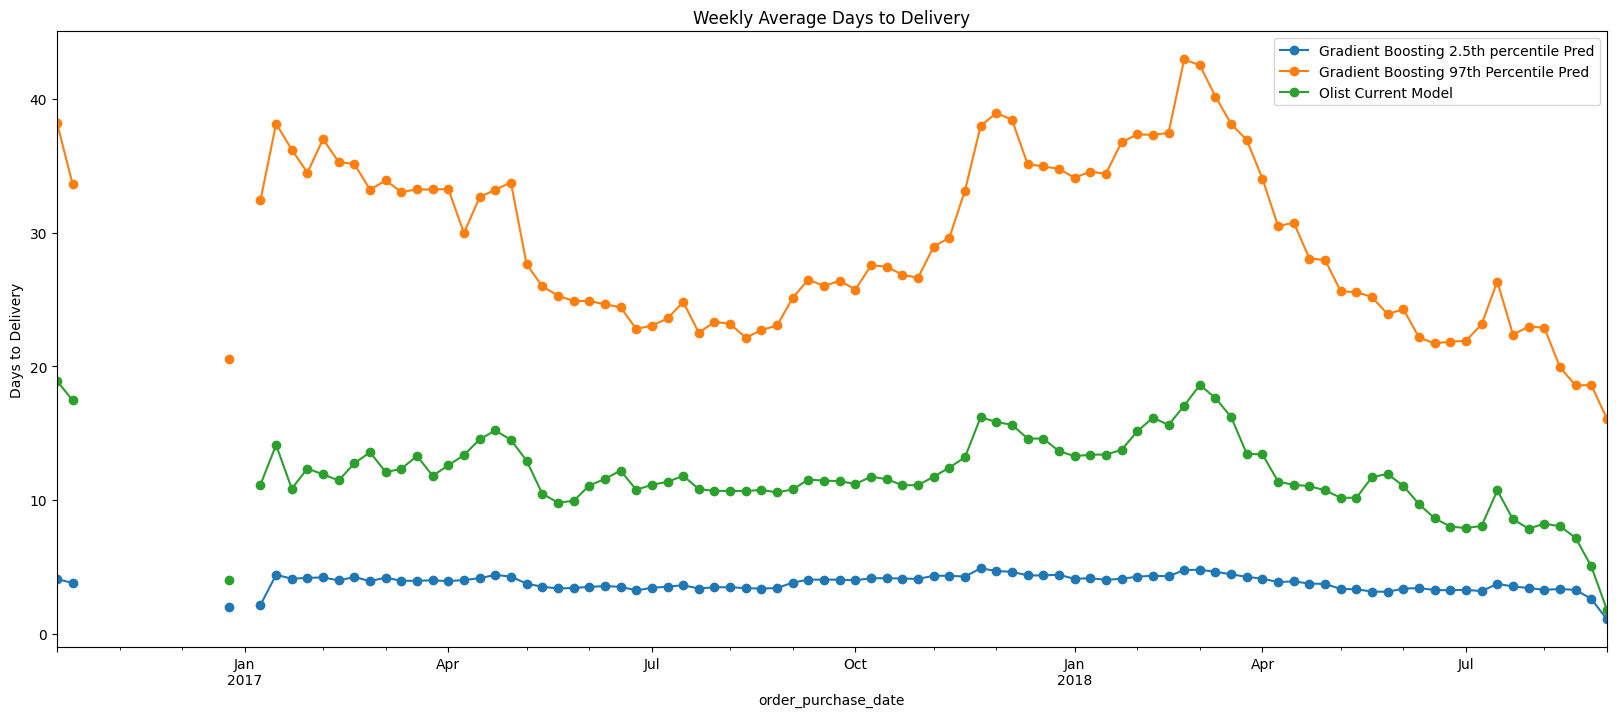

In [178]:
weekly_data_model_lb = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    days_to_estimated_delivery_lb = ('days_to_estimated_delivery_model_lb', 'mean'))

weekly_data_model_ub = df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    days_to_estimated_delivery_ub = ('days_to_estimated_delivery_model_ub', 'mean'))

weekly_data_model_actual= df_clean.groupby(pd.Grouper(key='order_purchase_date', freq='W')).agg(
    count_orders=('order_purchase_date', 'count'),
    days_to_actual_delivery = ('days_to_actual_delivery', 'mean'))


plt.figure(figsize=(20, 8))
weekly_data_model_lb['days_to_estimated_delivery_lb'].plot(label='Gradient Boosting 2.5th percentile Pred', marker='o')
weekly_data_model_ub['days_to_estimated_delivery_ub'].plot(label='Gradient Boosting 97th Percentile Pred', marker='o')
weekly_data_model_actual['days_to_actual_delivery'].plot(label='Olist Current Model', marker='o')
plt.legend()
plt.ylabel("Days to Delivery")
plt.title("Weekly Average Days to Delivery")
plt.show()

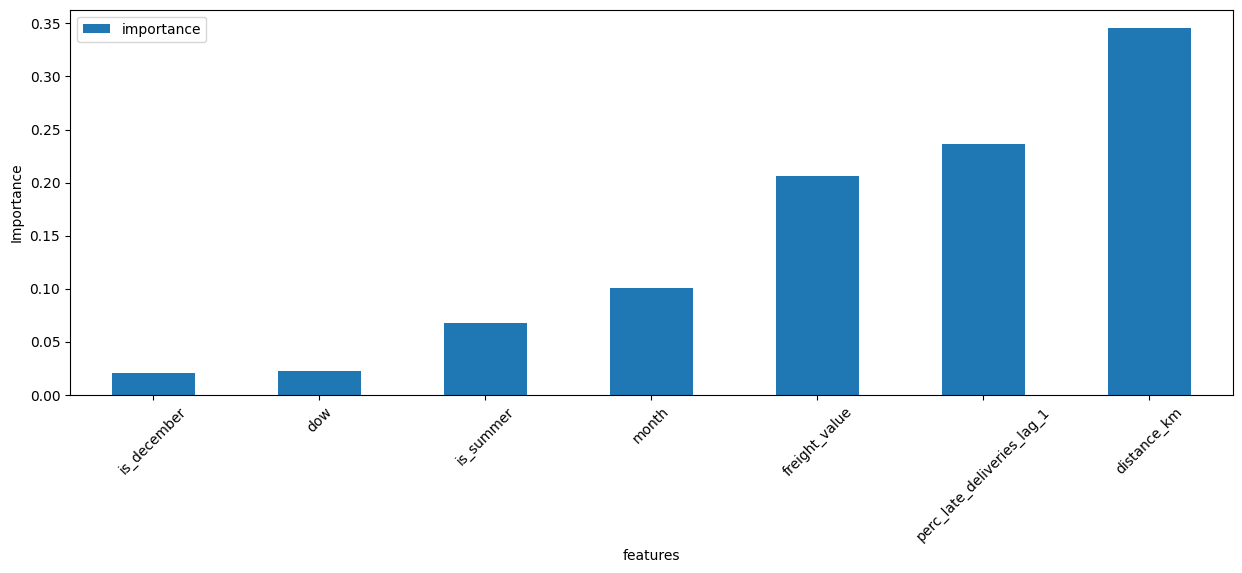

In [174]:
features_df = pd.DataFrame({'features':upper_model.feature_names_in_, 'importance': upper_model.feature_importances_})
features_df.sort_values(by='importance').set_index("features").plot(kind='bar', figsize=(15,5))
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

In [175]:
ldr_outside_ci = late_delivery_rate(y_true=y, y_pred=upper_bound)
print(f"Late Delivery Rate Outside CI: {ldr_outside_ci:.4f}")

Late Delivery Rate Outside CI: 0.0250


In [139]:
# Saving models
joblib.dump(lower_model, '../results/models/gb_model_lb.joblib')
joblib.dump(upper_model, '../results/models/gb_model_ub.joblib')

['../results/models/gb_model_ub.joblib']

# Business Recommendations: *Pursue the Small Wins*

Implementing changes in the supply chain may be costly, and it may require significant efforts to carry it out efficiently. On the other hand, limiting the capacity of order Olist receives in order to minimize late deliveries may result in fewer orders and a negative impact on revenue and profit.

As a result, we would love to propose to pursue the small win. Improve the current estimated delivery model and better manage customers expectations. This does not affect order capacities and the only cost may be the hours of work the engineers will have to put in order to deploy this model efficiently.

We have built a model that does not rely in predicting an exact delivery date, but an interval of when this will be delivered. Our model has a late delivery rate of less than 3%, improving Olist's current model by ~4%. This results in fewer late deliveries and we hope it affects customer satisfaction positively.

---

# Measuring Revenue Impact

Revenue Loss = (Total Customers * Late Delivery Rate) x Customer Lifetime Value x Impact Per Late Delivery

In [5]:
df.drop_duplicates(subset='order_id', inplace=True)

**Estimating customer LTV**

In [6]:
average_order_value = df['payment_value'].mean()
average_repeat_purchase = sum(df['customer_unique_id'].value_counts() > 1) / len(df['customer_unique_id'].unique()) * 100
customer_ltv = average_order_value * average_repeat_purchase
customer_ltv

np.float64(467.36663946493826)

**Ratings and customer behavior**

$ \text{number of purchases} = \beta_0 + \beta_1 \times \text{rating} $

In [184]:
def repeat_purchase_rate(rating):
    customers_with_more_than_one_purchase = sum(df[df['Rating'] == rating]['customer_unique_id'].value_counts() > 1) 
    total_customers = len(df[df['Rating'] == rating]['customer_unique_id'].unique())
    return customers_with_more_than_one_purchase/total_customers * 100

In [8]:
agg_df = df.groupby("customer_unique_id").agg(
                    avg_rating=('Rating', 'mean'),
                    number_of_purchases=('customer_unique_id', 'count') 
                ).reset_index()

agg_df['repeat_purchase'] = np.where(agg_df['number_of_purchases'] > 1, 1, 0)
agg_df['avg_rating_2'] = 6 - agg_df['avg_rating']

In [11]:
formula = 'number_of_purchases ~ avg_rating_2'
model = smf.ols(formula=formula, data=agg_df)
results = model.fit()
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     number_of_purchases   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     9.563
Date:                 Sun, 01 Dec 2024   Prob (F-statistic):            0.00199
Time:                         13:03:37   Log-Likelihood:                 13875.
No. Observations:                92740   AIC:                        -2.775e+04
Df Residuals:                    92738   BIC:                        -2.773e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.0362      0.001    

In [18]:
7400 * customer_ltv * (1.8 * -0.0017)

np.float64(-10583.050184044061)

In [19]:
2300 * customer_ltv * (1.8 * -0.0017)

np.float64(-3289.326408554235)

---

**Resources**

instacart technical blog: https://tech.instacart.com/building-a-data-science-product-in-10-days-d2f4688567b0

Wayfair technical blog: https://www.aboutwayfair.com/careers/tech-blog/delivery-date-prediction